# Generating a non-stationary dataset

Basically, we just take a sum of two GPs ($f_1$ and $f_2$), in which the value at each point is:

$$f(s_i) = w_if_1(s_i) + (1-w_i) f_2 (s_i)$$

subject to some constraints on $w$ (at each point $s_i$, the weights should sum to 1).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels

# Define the kernel
x_range = np.linspace(-1, 1, 50)
y_range = np.linspace(-1, 1, 50)

X1, X2 = np.meshgrid(x_range, y_range)
X = np.vstack((X1.ravel(), X2.ravel())).T

k1 = kernels.RBF(length_scale = 0.1) # rougher edges
k2 = kernels.RBF(length_scale = 0.5) # smoother edges

k1_true = k1(X)
k2_true = k2(X)

m1 = np.random.multivariate_normal(np.zeros(X.shape[0]), k1_true).reshape(X1.shape)
m2 = np.random.multivariate_normal(np.zeros(X.shape[0]), k2_true).reshape(X1.shape)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


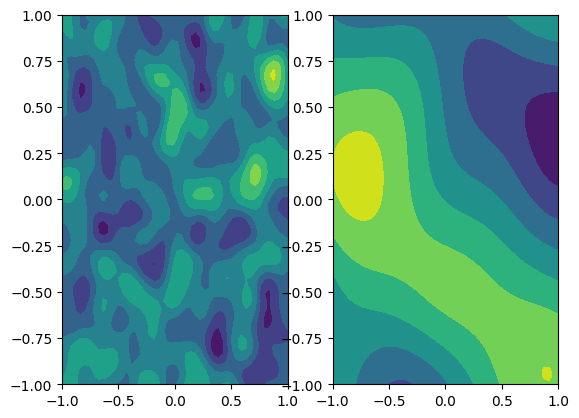

In [2]:
plt.subplot(1,2,1)
plt.contourf(X1, X2, m1)
plt.subplot(1,2,2)
plt.contourf(X1, X2, m2)

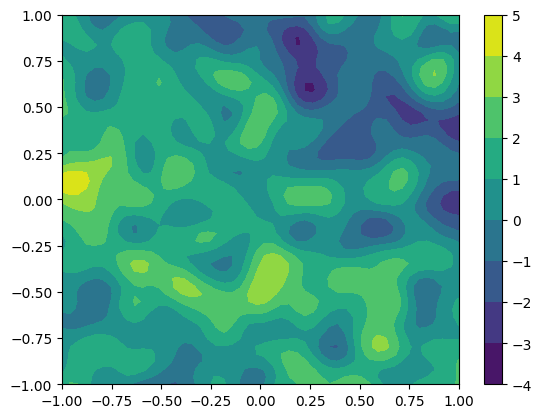

In [3]:
plt.contourf(X1, X2, m1 + m2)
plt.colorbar()

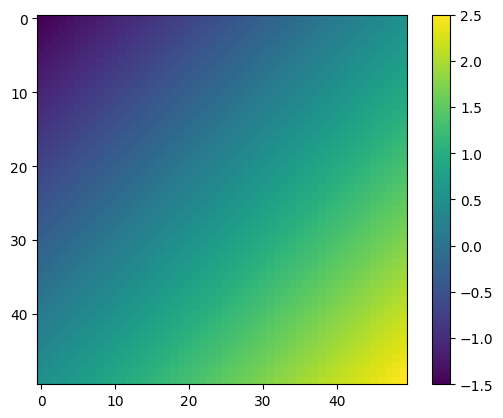

In [4]:
# How to generate the w piece
y = X1 + X2
w = y - y.min() / (y.max() - y.min())
plt.imshow(w)
plt.colorbar()

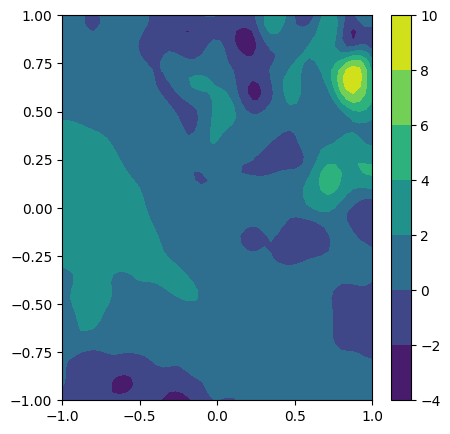

In [5]:
# Plot the non-stationary kernel
f = w * m1 + (1-w) * m2
plt.figure(figsize=(5,5))
plt.contourf(X1, X2, f)
plt.colorbar()

In [6]:
f.ravel().shape, X.shape

((2500,), (2500, 2))

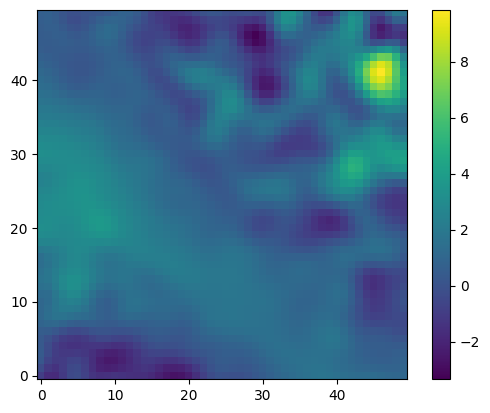

In [7]:
plt.imshow(f, origin='lower')
plt.colorbar()

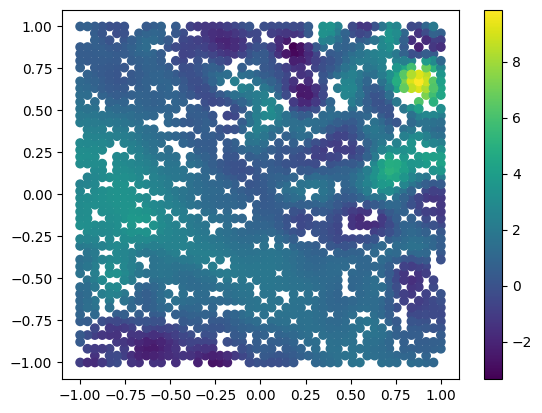

In [8]:
observed_coords = np.random.choice(X.shape[0], 2000, replace=False)
plt.scatter(X[observed_coords, 0], X[observed_coords, 1], c=f.flatten()[observed_coords])
plt.colorbar()
plt.show()

In [9]:
cd ..

/Users/edliao/Code/uhi-deep-learning


In [10]:
# Now import your module
from src.models import NonStationaryGPModel
import gpytorch
import torch
import itertools
import numpy as np
import matplotlib.pyplot as plt
from gpytorch.kernels import Kernel, MaternKernel

In [11]:
train_x = X[observed_coords]
train_x.shape

(2000, 2)

In [12]:
# Function to train the model
def train_model(train_x, train_y, likelihood, num_points=16):
    model = NonStationaryGPModel(train_x, train_y, likelihood, num_points)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float('inf')
    params = None

    print(f"RBF Centers: \n{model.covar_module.rbf_centers.detach().numpy()}")

    for i in range(50):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()

        print(f"Iter {i+1}/50 - Loss: {loss.item():.3f}")
        print(f"Base Kernel Lengthscale: \n{model.covar_module.base_kernel.lengthscale.item()}")
        print(f"RBF Widths: \n{model.covar_module.raw_rbf_widths.detach().numpy()}")
        print(f"Signal Variance: \n{model.covar_module.coefficients.detach().numpy()}")

        if loss.item() < best_loss:
            print('Saving model parameters...')
            best_loss = loss.item()
            params = model.state_dict()

        optimizer.step()

    return model, params

In [26]:
from src.models import ExactGPModel

In [30]:
# Function to train the model
def train_model_exact(train_x, train_y, likelihood, num_points=16):
    model = ExactGPModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float('inf')
    params = None

    # print(f"RBF Centers: \n{model.covar_module.rbf_centers.detach().numpy()}")

    for i in range(50):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()

        print(f"Iter {i+1}/50 - Loss: {loss.item():.3f}")
        # print(f"Base Kernel Lengthscale: \n{model.covar_module.base_kernel.lengthscale.item()}")
        # print(f"RBF Widths: \n{model.covar_module.raw_rbf_widths.detach().numpy()}")
        # print(f"Signal Variance: \n{model.covar_module.coefficients.detach().numpy()}")

        if loss.item() < best_loss:
            print('Saving model parameters...')
            best_loss = loss.item()
            params = model.state_dict()

        optimizer.step()

    return model, params

In [32]:
# Convert training data to PyTorch tensors
train_x = torch.tensor(X[observed_coords], dtype=torch.float32)
train_y = torch.tensor(f.ravel()[observed_coords], dtype=torch.float32)

# Define likelihood and GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Train the GP model using your Non-Stationary Kernel
# trained_model, _ = train_model(train_x, train_y, likelihood, num_points=4)
train_model_exact, _ = train_model_exact(train_x, train_y, likelihood, num_points=4)

Iter 1/50 - Loss: 1.352
Saving model parameters...
Iter 2/50 - Loss: 1.329
Saving model parameters...
Iter 3/50 - Loss: 1.304
Saving model parameters...
Iter 4/50 - Loss: 1.275
Saving model parameters...
Iter 5/50 - Loss: 1.243
Saving model parameters...
Iter 6/50 - Loss: 1.202
Saving model parameters...
Iter 7/50 - Loss: 1.160
Saving model parameters...
Iter 8/50 - Loss: 1.106
Saving model parameters...
Iter 9/50 - Loss: 1.047
Saving model parameters...
Iter 10/50 - Loss: 0.987
Saving model parameters...
Iter 11/50 - Loss: 0.911
Saving model parameters...
Iter 12/50 - Loss: 0.845
Saving model parameters...
Iter 13/50 - Loss: 0.782
Saving model parameters...
Iter 14/50 - Loss: 0.720
Saving model parameters...
Iter 15/50 - Loss: 0.661
Saving model parameters...
Iter 16/50 - Loss: 0.617
Saving model parameters...
Iter 17/50 - Loss: 0.579
Saving model parameters...
Iter 18/50 - Loss: 0.533
Saving model parameters...
Iter 19/50 - Loss: 0.517
Saving model parameters...
Iter 20/50 - Loss: 0.

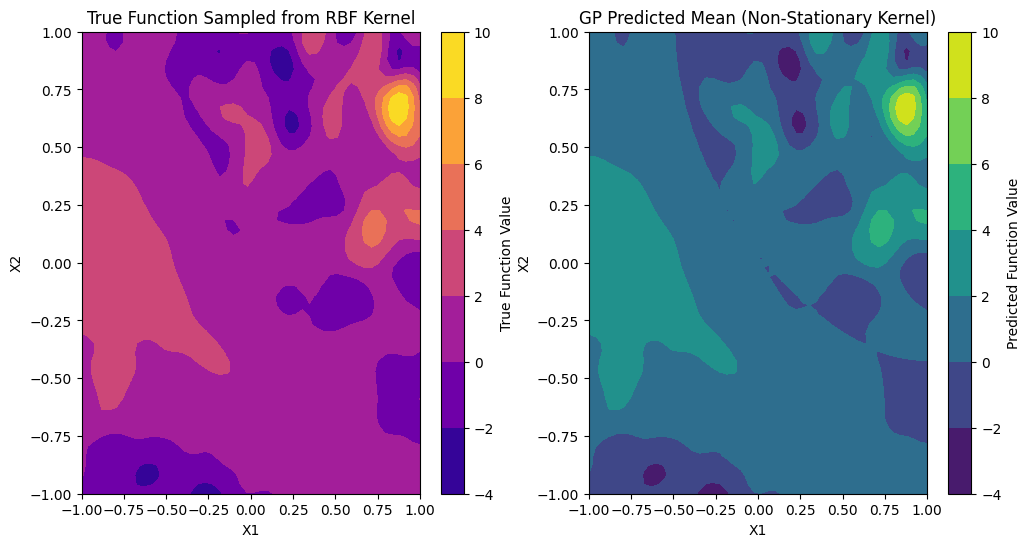

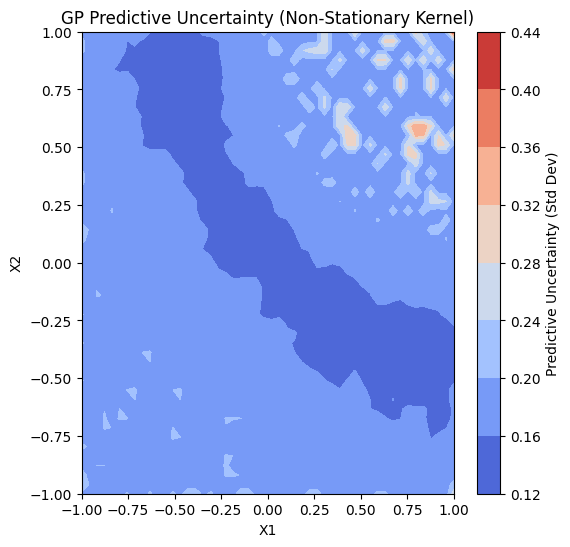

In [15]:
# Function to generate predictions using the trained GP model
def generate_predictions(model, likelihood, test_x):
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        predictive_dist = likelihood(model(test_x))  # GP predictive distribution
        mean_pred = predictive_dist.mean.numpy()

        # Directly extract diagonal variance from covariance matrix
        std_pred = torch.sqrt(predictive_dist.covariance_matrix.diagonal()).numpy()

    return mean_pred, std_pred

# Generate a grid of test points
test_x = torch.tensor(X, dtype=torch.float32)

# Generate predictions for test points
mean_pred, std_pred = generate_predictions(trained_model, likelihood, test_x)

# Reshape predictions to match the grid
mean_pred_reshaped = mean_pred.reshape(X1.shape)
std_pred_reshaped = std_pred.reshape(X1.shape)

# Plot True Function vs. Predicted Mean
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# True function (from synthetic RBF data)
contour1 = ax[0].contourf(X1, X2, f, cmap="plasma")
fig.colorbar(contour1, ax=ax[0], label="True Function Value")  # Corrected

ax[0].set_title("True Function Sampled from RBF Kernel")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")

# GP predicted mean
contour2 = ax[1].contourf(X1, X2, mean_pred_reshaped, cmap="viridis")
fig.colorbar(contour2, ax=ax[1], label="Predicted Function Value")  # Corrected

ax[1].set_title("GP Predicted Mean (Non-Stationary Kernel)")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")

plt.show()

# Plot Standard Deviation (Uncertainty Estimates)
plt.figure(figsize=(6, 6))
contour3 = plt.contourf(X1, X2, std_pred_reshaped, cmap="coolwarm")
plt.colorbar(label="Predictive Uncertainty (Std Dev)")
plt.title("GP Predictive Uncertainty (Non-Stationary Kernel)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(f.ravel(), mean_pred))

# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 0.1223


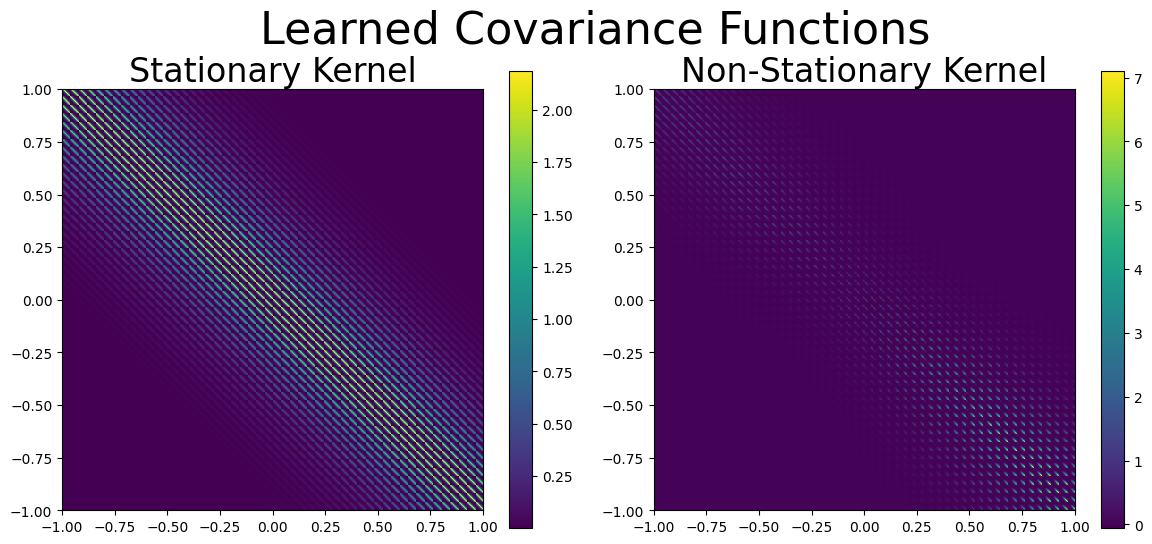

In [47]:
# Compute the learned covariance matrix from the trained model
def compute_learned_covariance(model, test_x):
    model.eval()
    with torch.no_grad():
        cov_matrix = model.covar_module(test_x, test_x).evaluate()
    return cov_matrix

# Generate test points
test_x = torch.tensor(X, dtype=torch.float32)

# Compute the learned covariance matrix
K_learned = compute_learned_covariance(trained_model, test_x)
K_learned_stat = compute_learned_covariance(train_model_exact, test_x)

# Plot the learned covariance function
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))
im1 = axes[0].imshow(K_learned_stat.numpy(), cmap="viridis", interpolation="nearest", extent=(-1, 1, -1, 1))
axes[0].set_title("Stationary Kernel", fontsize=24)
fig.colorbar(im1, ax=axes[0])


im2 = axes[1].imshow(K_learned.numpy(), cmap="viridis", interpolation="nearest", extent=(-1, 1, -1, 1))
axes[1].set_title("Non-Stationary Kernel", fontsize=24)
fig.colorbar(im2, ax=axes[1])

plt.suptitle("Learned Covariance Functions", fontsize=32)
plt.tight_layout()

plt.show()